In [1]:
import pandas as pd
from microscopium.screens import image_xpress
import os
import numpy as np
from sklearn import svm
from sklearn import cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import pylab
import matplotlib.pyplot as plt
import matplotlib
import brewer2mpl

%matplotlib inline  
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Fun with the BBBC021 dataset

* This uses the [BBBC021](https://www.broadinstitute.org/bbbc/BBBC021/) dataset, a screen of MCF-7 breast cancer cells treated with a library of 113 compounds. A subset (103 wells) have been annotated such that the compounds they were treated have been placed in 12 categories.
* I ran the feature extraction using Microscopium's object features, and some additional features of my choosing. These are [Haralick texture features](http://murphylab.web.cmu.edu/publications/boland/boland_node26.html) and [threshold adjacancy statistics](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-110).
* Even though Microscopium is designed with unsupervised clustering and dimensionality reduction in mind, these annotated data-sets are useful because we can quantify how useful features are and whether or not the clustering scheme preserves the ground truth labels.

## The boring bit
First we need to wrangle the metadata into useable format.

In [2]:
# first load in the screen metadata
bbbc021_metadata = pd.read_csv("./BBBC021_v1_image.csv")

# now load in the mechanism of action metadata, these map
# compouds to a class of compounds
bbbc021_moa = pd.read_csv("./BBBC021_v1_moa.csv")

In [3]:
# wrangle the metadata into a form that maps screen-plate-well format IDs
# to the compound it was treated with. this dataset contains no controls or
# empty wells, so we don't need to worry about those!!

# first only keep the colums we want -- 
# Image_FileName_DAPI, Image_PathName_DAPI, Image_Metadata_Compound, Image_Metadata_Concentration
bbbc021_metadata = bbbc021_metadata[["Image_FileName_DAPI",
                                     "Image_PathName_DAPI",
                                     "Image_Metadata_Compound", 
                                     "Image_Metadata_Concentration"]]

def fn_to_id(fn):
    sem = image_xpress.ix_semantic_filename(fn)
    return "{0}-{1}-{2}".format("BBBC021", sem["plate"], sem["well"])

# merge the Image_PathName_DAPI and Image_FileName_DAPI column with os.path.join
fn_cols = zip(bbbc021_metadata["Image_PathName_DAPI"], bbbc021_metadata["Image_FileName_DAPI"])
bbbc021_metadata.index = list(map(fn_to_id, [os.path.join(i, j) for (i, j) in fn_cols]))
bbbc021_metadata = bbbc021_metadata[["Image_Metadata_Compound", "Image_Metadata_Concentration"]]
bbbc021_metadata.head()

,Image_Metadata_Compound,Image_Metadata_Concentration
BBBC021-27481-G10,5-fluorouracil,0.003
BBBC021-27481-G10,5-fluorouracil,0.003
BBBC021-27481-G10,5-fluorouracil,0.003
BBBC021-27481-G10,5-fluorouracil,0.003
BBBC021-27521-G10,5-fluorouracil,0.003


In [4]:
# good idea to check that different concentrations don't 
# change the expected mechanism of action in the annotations
bbbc021_moa.groupby(['compound', 'moa']).count()

,,concentration
compound,moa,
ALLN,Protein degradation,2
AZ-A,Aurora kinase inhibitors,6
AZ-C,Eg5 inhibitors,7
AZ-J,Epithelial,3
AZ-U,Epithelial,3
AZ138,Eg5 inhibitors,5
AZ258,Aurora kinase inhibitors,3
AZ841,Aurora kinase inhibitors,3
DMSO,DMSO,1


In [5]:
# now merge the dataframes!
right_cols = ["compound", "concentration"]
bbbc021_merged = bbbc021_metadata.reset_index().merge(
    bbbc021_moa, how="outer", 
    left_on=["Image_Metadata_Compound", "Image_Metadata_Concentration"], 
    right_on=right_cols).set_index("index").dropna().drop_duplicates()

In [6]:
# only a subset of the data was annotated -- 103
# how are the classes distributed?
bbbc021_merged.head()
bbbc021_merged.groupby("moa").count()

,Image_Metadata_Compound,Image_Metadata_Concentration,compound,concentration
moa,,,,
Actin disruptors,5,5,5,5
Aurora kinase inhibitors,12,12,12,12
Cholesterol-lowering,6,6,6,6
DMSO,1,1,1,1
DNA damage,9,9,9,9
DNA replication,8,8,8,8
Eg5 inhibitors,12,12,12,12
Epithelial,8,8,8,8
Kinase inhibitors,5,5,5,5


In [7]:
# only one example for the "DMSO" class. remove this.
bbbc021_merged = bbbc021_merged[bbbc021_merged["compound"] != "DMSO"]

In [8]:
# now load the feature data frame
bbbc021_complete = pd.read_csv("./BBBC021_feature.csv", index_col=0)
# we only want the feature vectors for samples that were annotated
bbbc021_feature = bbbc021_complete.ix[bbbc021_merged.index]
bbbc021_feature.head()

,chan0-num-objs-per-field,chan0-area-percentile5,chan0-area-percentile25,chan0-area-percentile50,chan0-area-percentile75,chan0-area-percentile95,chan0-eccentricity-percentile5,chan0-eccentricity-percentile25,chan0-eccentricity-percentile50,chan0-eccentricity-percentile75,...,chan2-pftas45,chan2-pftas46,chan2-pftas47,chan2-pftas48,chan2-pftas49,chan2-pftas50,chan2-pftas51,chan2-pftas52,chan2-pftas53,chan2-pftas54
index,,,,,,,,,,,,,,,,,,,,,
BBBC021-22123-B04,82.00,334.93,681.90,940.0,1200.10,1850.23,0.409342,0.640938,0.754656,0.831699,...,0.001030,0.559508,0.097665,0.076829,0.110700,0.083324,0.047067,0.014472,0.007057,0.003377
BBBC021-22123-B03,53.50,313.22,600.90,779.5,1089.15,2346.68,0.438146,0.612522,0.721969,0.817265,...,0.000646,0.615476,0.092003,0.072895,0.093689,0.068061,0.038294,0.011432,0.005477,0.002674
BBBC021-24121-B06,72.00,367.81,572.85,804.0,967.50,1714.47,0.346730,0.603215,0.717655,0.832297,...,0.000072,0.749531,0.068329,0.048124,0.071313,0.045267,0.012705,0.003083,0.001237,0.000410
BBBC021-22361-B06,138.50,218.88,570.95,978.5,1522.50,2474.56,0.453993,0.676182,0.786166,0.863285,...,0.000776,0.718063,0.076562,0.059223,0.064269,0.042778,0.020447,0.010393,0.005850,0.002416
BBBC021-22361-B05,109.75,23.36,571.60,855.0,1191.00,2446.48,0.340896,0.614730,0.759387,0.851912,...,0.000702,0.705563,0.074144,0.056653,0.072273,0.050967,0.025128,0.008891,0.004488,0.001894


In [9]:
# Now scale the dataframe and we're good to go!
std = StandardScaler().fit_transform(bbbc021_feature.values)
bbbc021_feature = pd.DataFrame(std, columns=bbbc021_feature.columns, index=bbbc021_feature.index)

## Supervised learning

Now we have our training data. Let's try it with a simple linear SVM using the full set of features. Why SVM? A linear SVM is simple, performs well and the weights can be used to quantify feature importance. First a quick 5-fold cross validation to check it can discriminate between classes.

In [10]:
classifier = svm.SVC(kernel='linear', C=1)
scores = cross_validation.cross_val_score(classifier, 
                                          bbbc021_feature.values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
sum(scores / 5)

0.81031746031746033

Hey, that's not bad!! Previous studies have ~90% accuracy but they've done lots more fine-tuning of the features and segmentation pipeline. The features show the data is somewhat linearly seperable. Let's see how object features, texture features and threshold adjacancy statistics perform on their own.

In [11]:
object_cols = [col for col in bbbc021_feature.columns if "pftas" not in col and "haralick" not in col]
haralick_cols = [col for col in bbbc021_feature.columns if "haralick" in col]
pftas_cols = [col for col in bbbc021_feature.columns if "pftas" in col]

In [12]:
scores = cross_validation.cross_val_score(classifier, 
                                          bbbc021_feature[object_cols].values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
sum(scores / 5)

0.82131746031746033

In [13]:
scores = cross_validation.cross_val_score(classifier, 
                                          bbbc021_feature[haralick_cols].values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
sum(scores / 5)

0.33047619047619048

In [14]:
scores = cross_validation.cross_val_score(classifier, 
                                          bbbc021_feature[pftas_cols].values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
sum(scores / 5)

0.83350793650793653

Wow! Object and PFTAS features do great on their own. What if we tried both?

In [15]:
object_pftas_cols = [col for col in bbbc021_feature.columns if "haralick" not in col]
scores = cross_validation.cross_val_score(classifier, 
                                          bbbc021_feature[object_pftas_cols].values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
sum(scores / 5)

0.85195238095238091

85%! That's the best performance yet. Let's look at some feature importance scores using ExtraTrees. We can use this model to get Gini coefficients for each feature.

In [16]:
et_classifier = ExtraTreesClassifier()
et_classifier.fit(bbbc021_feature[object_pftas_cols].values, bbbc021_merged["moa"].values)

feature_scores = pd.DataFrame(data={"feature": bbbc021_feature[object_pftas_cols].columns, 
                                    "gini": et_classifier.feature_importances_})
feature_scores = feature_scores.sort_values(by="gini", ascending=False)

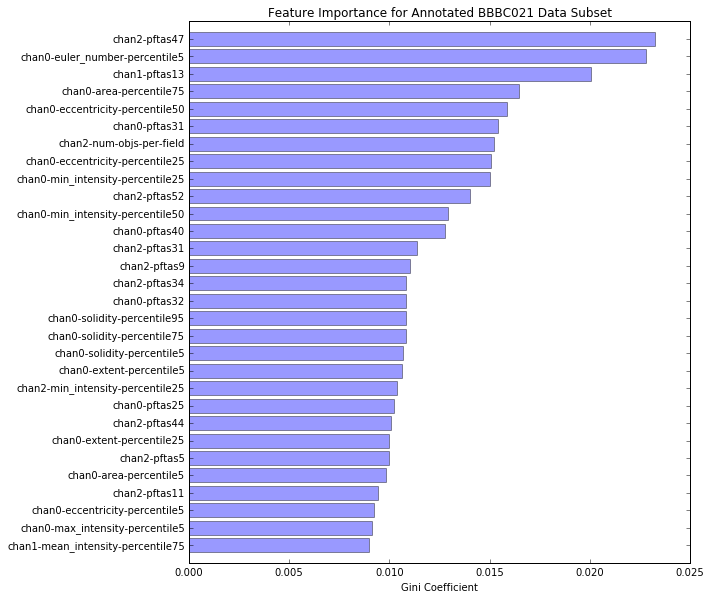

In [17]:
top_k = 30

plt.barh(np.arange(top_k), feature_scores.head(top_k)["gini"], align="center", alpha=0.4)
plt.ylim([top_k, -1])
plt.yticks(np.arange(top_k), feature_scores.head(30)["feature"])
plt.tight_layout()
plt.title("Feature Importance for Annotated BBBC021 Data Subset")
plt.xlabel("Gini Coefficient")
plt.show()

Features across all three channels, and a mixture of both object and adjacancy threshold statistics contribute as the most important features. There's no evidence to suggest that one particular feature dominates here. 

## Supervised Learning - Independence of Features

How accurate if the classification if we take random subsets of features? We've shown pretty clearly that no feature dominates by means of the gini coefficients, but we can demonstrate this further by training classifiers with random subsets of features and seeing how they perform. Let's train them with say, 65% of the features.

In [18]:
n_features = bbbc021_feature[object_pftas_cols].shape[1]
sample_size = int(np.round(n_features * 0.65))

all_scores = []
for i in range(10000):
    random_index = np.random.choice(np.arange(n_features), sample_size)
    scores = cross_validation.cross_val_score(classifier, 
                                          bbbc021_feature[object_pftas_cols][random_index].values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
    cv_score = sum(scores / 5)
    all_scores.append(cv_score)

In [19]:
pd.DataFrame(all_scores).describe()

,0
count,10000.000000
mean,0.859665
std,0.024358
min,0.756603
25%,0.843131
50%,0.860619
75%,0.876619
max,0.937111


The accuracy of the classifier is robust against random subsetting of the data. Maximum classifier is as high as ~90% on some subset(s) of the data.

## Unsupervised Learning

The next task is to cluster the feature vectors into 11 clusters and see how well the original labels are represented. I'll use Agglomerative Clustering with the Cosine distance.

In [20]:
ag_clustering = AgglomerativeClustering(n_clusters=12, affinity="cosine", linkage="complete")
ag_predict = ag_clustering.fit_predict(X=bbbc021_feature[object_pftas_cols].values)

metrics.adjusted_rand_score(bbbc021_merged["moa"].values, ag_predict)

0.4862135828349653

Not great, but they're not completely random either. 

## Dimensionality Reduction

Now we look at the PCA and TSNE embeddings. This is the real test, seeing as the PCA and TSNE embeddings of the data drive the Microscopium interface.

In [21]:
rand_seed = 42

bbbc021_pca = PCA(n_components=2).fit_transform(bbbc021_feature[object_pftas_cols].values)
bbbc021_pca_50 = PCA(n_components=50).fit_transform(bbbc021_feature[object_pftas_cols].values)
bbbc021_tsne = TSNE(n_components=2, learning_rate=100, random_state=42).fit_transform(bbbc021_pca_50)

In [22]:
labels = list(set(bbbc021_merged["moa"]))
bmap = brewer2mpl.get_map("Paired", "Qualitative", 12)
color_scale = dict(zip(labels, bmap.mpl_colors))

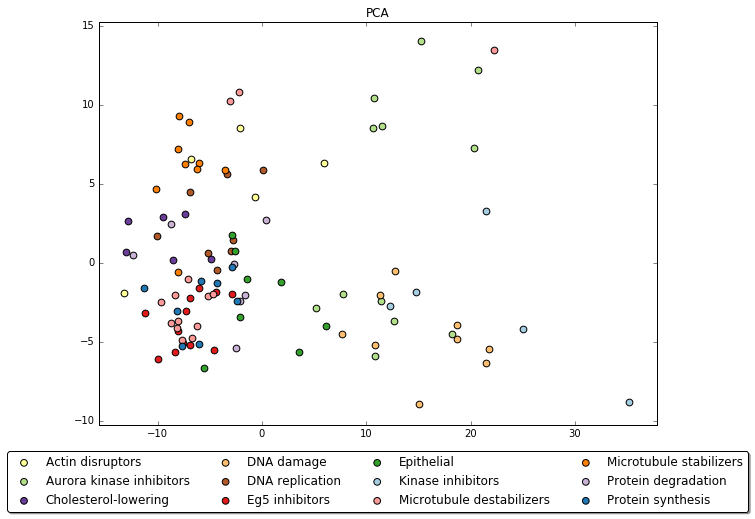

In [23]:
bbbc021_pca_df = pd.DataFrame(dict(x=bbbc021_pca[:, 0], 
                              y=bbbc021_pca[:, 1], 
                              label=bbbc021_merged["moa"].values), 
                              index=bbbc021_feature.index)
groups = bbbc021_pca_df.groupby('label')

fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.scatter(group.x, group.y, s=45, label=name, c=color_scale[name])
ax.legend(scatterpoints=1, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.title("PCA")

fig = plt.gcf()
fig.subplots_adjust(bottom=0.2)

plt.show()

The PCA embedding isn't particularly useful.

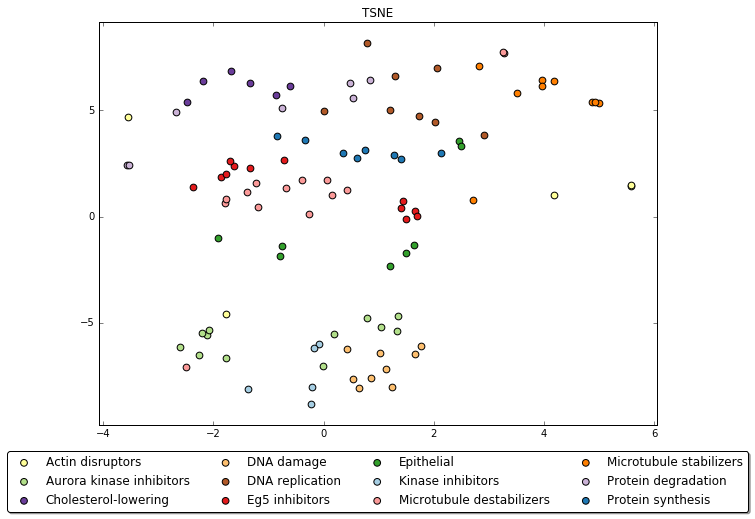

In [24]:
bbbc021_tsne_df = pd.DataFrame(dict(x=bbbc021_tsne[:, 0], 
                                    y=bbbc021_tsne[:, 1], 
                                    label=bbbc021_merged["moa"].values), 
                               index=bbbc021_feature.index)
groups = bbbc021_tsne_df.groupby('label')

fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.scatter(group.x, group.y, s=45, label=name, c=color_scale[name])
ax.legend(scatterpoints=1, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.title("TSNE")

fig = plt.gcf()
fig.subplots_adjust(bottom=0.2)

plt.show()

TSNE's is much better. We get some tight clusters and individual categories tend to stay close.

## Can TSNE embeddings classify examples?

Finally, we plot together 10 randomly chosen examples along with the annotated examples. The idea here is to find samples that group together. We can then look up the compound and determine if it's in the same category of compound. 

## Conclusions
* Based on the peformance of the supervised classifier, object features in tandem with threshold adjacancy statistics perform the best. There's evidence to suggest the texture features are useless, but it'd be good to try this against another data-set with ground-truth labels.

In [25]:
np.random.seed(13)

# get the set difference of indices in the whole dataset, and indices 
unannot_index = np.setdiff1d(bbbc021_complete.index, bbbc021_feature.index)

# get 20 random examples from the data frame
unannot_sample = np.random.choice(unannot_index, 10)

# combine these samples with the annotated ones, rescale the data-frame
bbbc021_new = bbbc021_complete.ix[bbbc021_feature.index | unannot_sample]


bbbc021_new_std = StandardScaler().fit_transform(bbbc021_new.values)
bbbc021_new = pd.DataFrame(bbbc021_new_std, columns=bbbc021_new.columns, index=bbbc021_new.index)

# embed to tsne
bbbc021_new_pca_50 = PCA(n_components=50).fit_transform(bbbc021_new.values)
bbbc021_new_tsne = TSNE(n_components=2, learning_rate=45, random_state=rand_seed).fit_transform(bbbc021_new_pca_50)

bbbc021_new_tsne_df = pd.DataFrame(dict(x=bbbc021_new_tsne[:, 0], 
                                        y=bbbc021_new_tsne[:, 1]), 
                                   index=bbbc021_new.index)

# add moa labels
bbbc021_new_tsne_df = bbbc021_new_tsne_df.merge(bbbc021_merged, 
                                                how="outer", 
                                                left_index=True, 
                                                right_index=True)

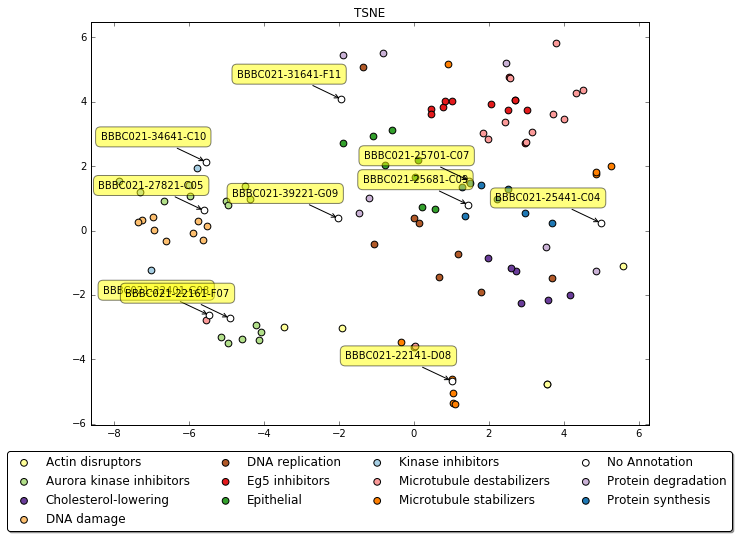

In [26]:
groups = bbbc021_new_tsne_df.fillna("No Annotation").groupby('moa')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups:
    color = color_scale.get(name)
    if color is None:
        color = (1, 1, 1)
    ax.scatter(group.x, group.y, s=45, label=name, c=color)

ax.legend(scatterpoints=1, loc='upper center', bbox_to_anchor=(0.5, -0.05),
      fancybox=True, shadow=True, ncol=4)
plt.title("TSNE")

for idx in unannot_sample:
    row = bbbc021_new_tsne_df.ix[idx]
    
    plt.annotate(
        idx, 
        xy = (row[0], row[1]), xytext = (0, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2)

plt.show()

Woo, I've never matplotlibbed that hard before. Of the unannotated samples, I make the following observations:

* BBBC021-22141-D08 clusters together tightly with the Microtubule stabilizers
* BBBC021-25701-C07 and BBBC021-25681-C09 group together with Protein synthesis
* BBBC021-22161-F07 clusters together with the Auroroa kinase stabilizers
* BBBC021-27821-C05 clusters loosely with DNA damagers
* BBBC021-34641-C10 groups with Kinase inhibitors

Are these groupings at all relevant? If we look up their corresponding compounds, does the mechanism of action of the samples they were clustered with agree?? Let's get their compunds.

In [27]:
selected_indices = ["BBBC021-22141-D08", 
                    "BBBC021-25701-C07", 
                    "BConclusionsBBC021-22161-F07", 
                    "BBBC021-27821-C05",
                    "BBBC021-25681-C09", 
                    "BBBC021-34641-C10"]

bbbc021_metadata.ix[selected_indices].drop_duplicates()

,Image_Metadata_Compound,Image_Metadata_Concentration
BBBC021-22141-D08,taxol,0.0100
BBBC021-25701-C07,emetine,0.3000
BConclusionsBBC021-22161-F07,NaN,NaN
BBBC021-27821-C05,AZ258,3.0000
BBBC021-25681-C09,emetine,0.0300
BBBC021-34641-C10,docetaxel,0.0003


* taxol is a microtubule stabilizer! https://pubchem.ncbi.nlm.nih.gov/compound/paclitaxel
* emetine is involved in protein synthesis inhibition -- https://pubchem.ncbi.nlm.nih.gov/compound/10219 and its neighbouring samples are annotated as "Protein synthesis", so I'll take this as a positive result
* AZ258 was annotated as a DNA damager, but this concentration wasn't annotated.
* AZ-H, couldn't find which compound this was exactly despite my best efforts.
* docetaxel is a Microtubule Inhibitor per pubchem https://pubchem.ncbi.nlm.nih.gov/compound/docetaxel, but the TSNE grouping suggests it's a Kinase inhibitor. Not a close match.

## Conclusions

* When used in a supervised classifier, the features perform with 85% 5-fold cross validation accuracy using a linear SVM. Object features along with the threshold adjacancy statistics give the best performance.
* Based on the gini coefficient, features across all three channels are useful in classification.
* Classifier results are robust against random subsetting of the features, i.e. features are independent.
* TSNE far outperforms PCA, where sample labels are somewhat faithfully preserved.
* Manually annotating a few samples based on their TSNE embedding seems to preserve the grouping.